# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [9]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

# Statsmodels for regression analysis
import statsmodels.api as sm

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [10]:
# Importing the file porter_data_1.csv
from google.colab import files
uploaded = files.upload()

Saving porter_data_1.csv to porter_data_1 (1).csv


In [11]:
df = pd.read_csv('porter_data_1.csv')


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [12]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [13]:
# Convert categorical features to category type

df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')


In [14]:
#verifying the change

print("\nData types after conversion:")
print(df[['store_primary_category', 'order_protocol']].dtypes)


Data types after conversion:
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [15]:
# Calculate time taken in minutes

df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Checking the result
print(df[['created_at', 'actual_delivery_time', 'delivery_time_minutes']])


                created_at actual_delivery_time  delivery_time_minutes
0      2015-02-06 22:24:17  2015-02-06 23:11:17                   47.0
1      2015-02-10 21:49:25  2015-02-10 22:33:25                   44.0
2      2015-02-16 00:11:35  2015-02-16 01:06:35                   55.0
3      2015-02-12 03:36:46  2015-02-12 04:35:46                   59.0
4      2015-01-27 02:12:36  2015-01-27 02:58:36                   46.0
...                    ...                  ...                    ...
175772 2015-02-17 00:19:41  2015-02-17 01:02:41                   43.0
175773 2015-02-13 00:01:59  2015-02-13 01:03:59                   62.0
175774 2015-01-24 04:46:08  2015-01-24 05:32:08                   46.0
175775 2015-02-01 18:18:15  2015-02-01 19:03:15                   45.0
175776 2015-02-08 19:24:33  2015-02-08 20:01:33                   37.0

[175777 rows x 3 columns]


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [16]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
# day of the week (0 = Monday, 6 = Sunday)
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
# 1 if Saturday or Sunday, else 0
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

print(df[['order_hour', 'order_dayofweek', 'isWeekend']])

        order_hour  order_dayofweek  isWeekend
0               22                4          0
1               21                1          0
2                0                0          0
3                3                3          0
4                2                1          0
...            ...              ...        ...
175772           0                1          0
175773           0                4          0
175774           4                5          1
175775          18                6          1
175776          19                6          1

[175777 rows x 3 columns]


In [17]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [18]:
# Define target variable (y) and features (X)

y = df['delivery_time_minutes']

# Define input features by dropping target and any irrelevant columns (like IDs if needed)
X = df.drop(columns=['delivery_time_minutes'])

# Preview shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")



Shape of X: (175777, 15)
Shape of y: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [19]:
# Split data into training and testing sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")



X_train shape: (123043, 15)
X_val shape: (52734, 15)
y_train shape: (123043,)
y_val shape: (52734,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [20]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Separate columns by data type
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='category').columns.tolist()

# Add manually any object columns that are actually categorical (just in case)
for col in X_train.select_dtypes(include='object').columns:
    if X_train[col].nunique() < 20:
        categorical_cols.append(col)


# Display results
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_dayofweek', 'isWeekend']
Categorical columns: ['store_primary_category', 'order_protocol']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

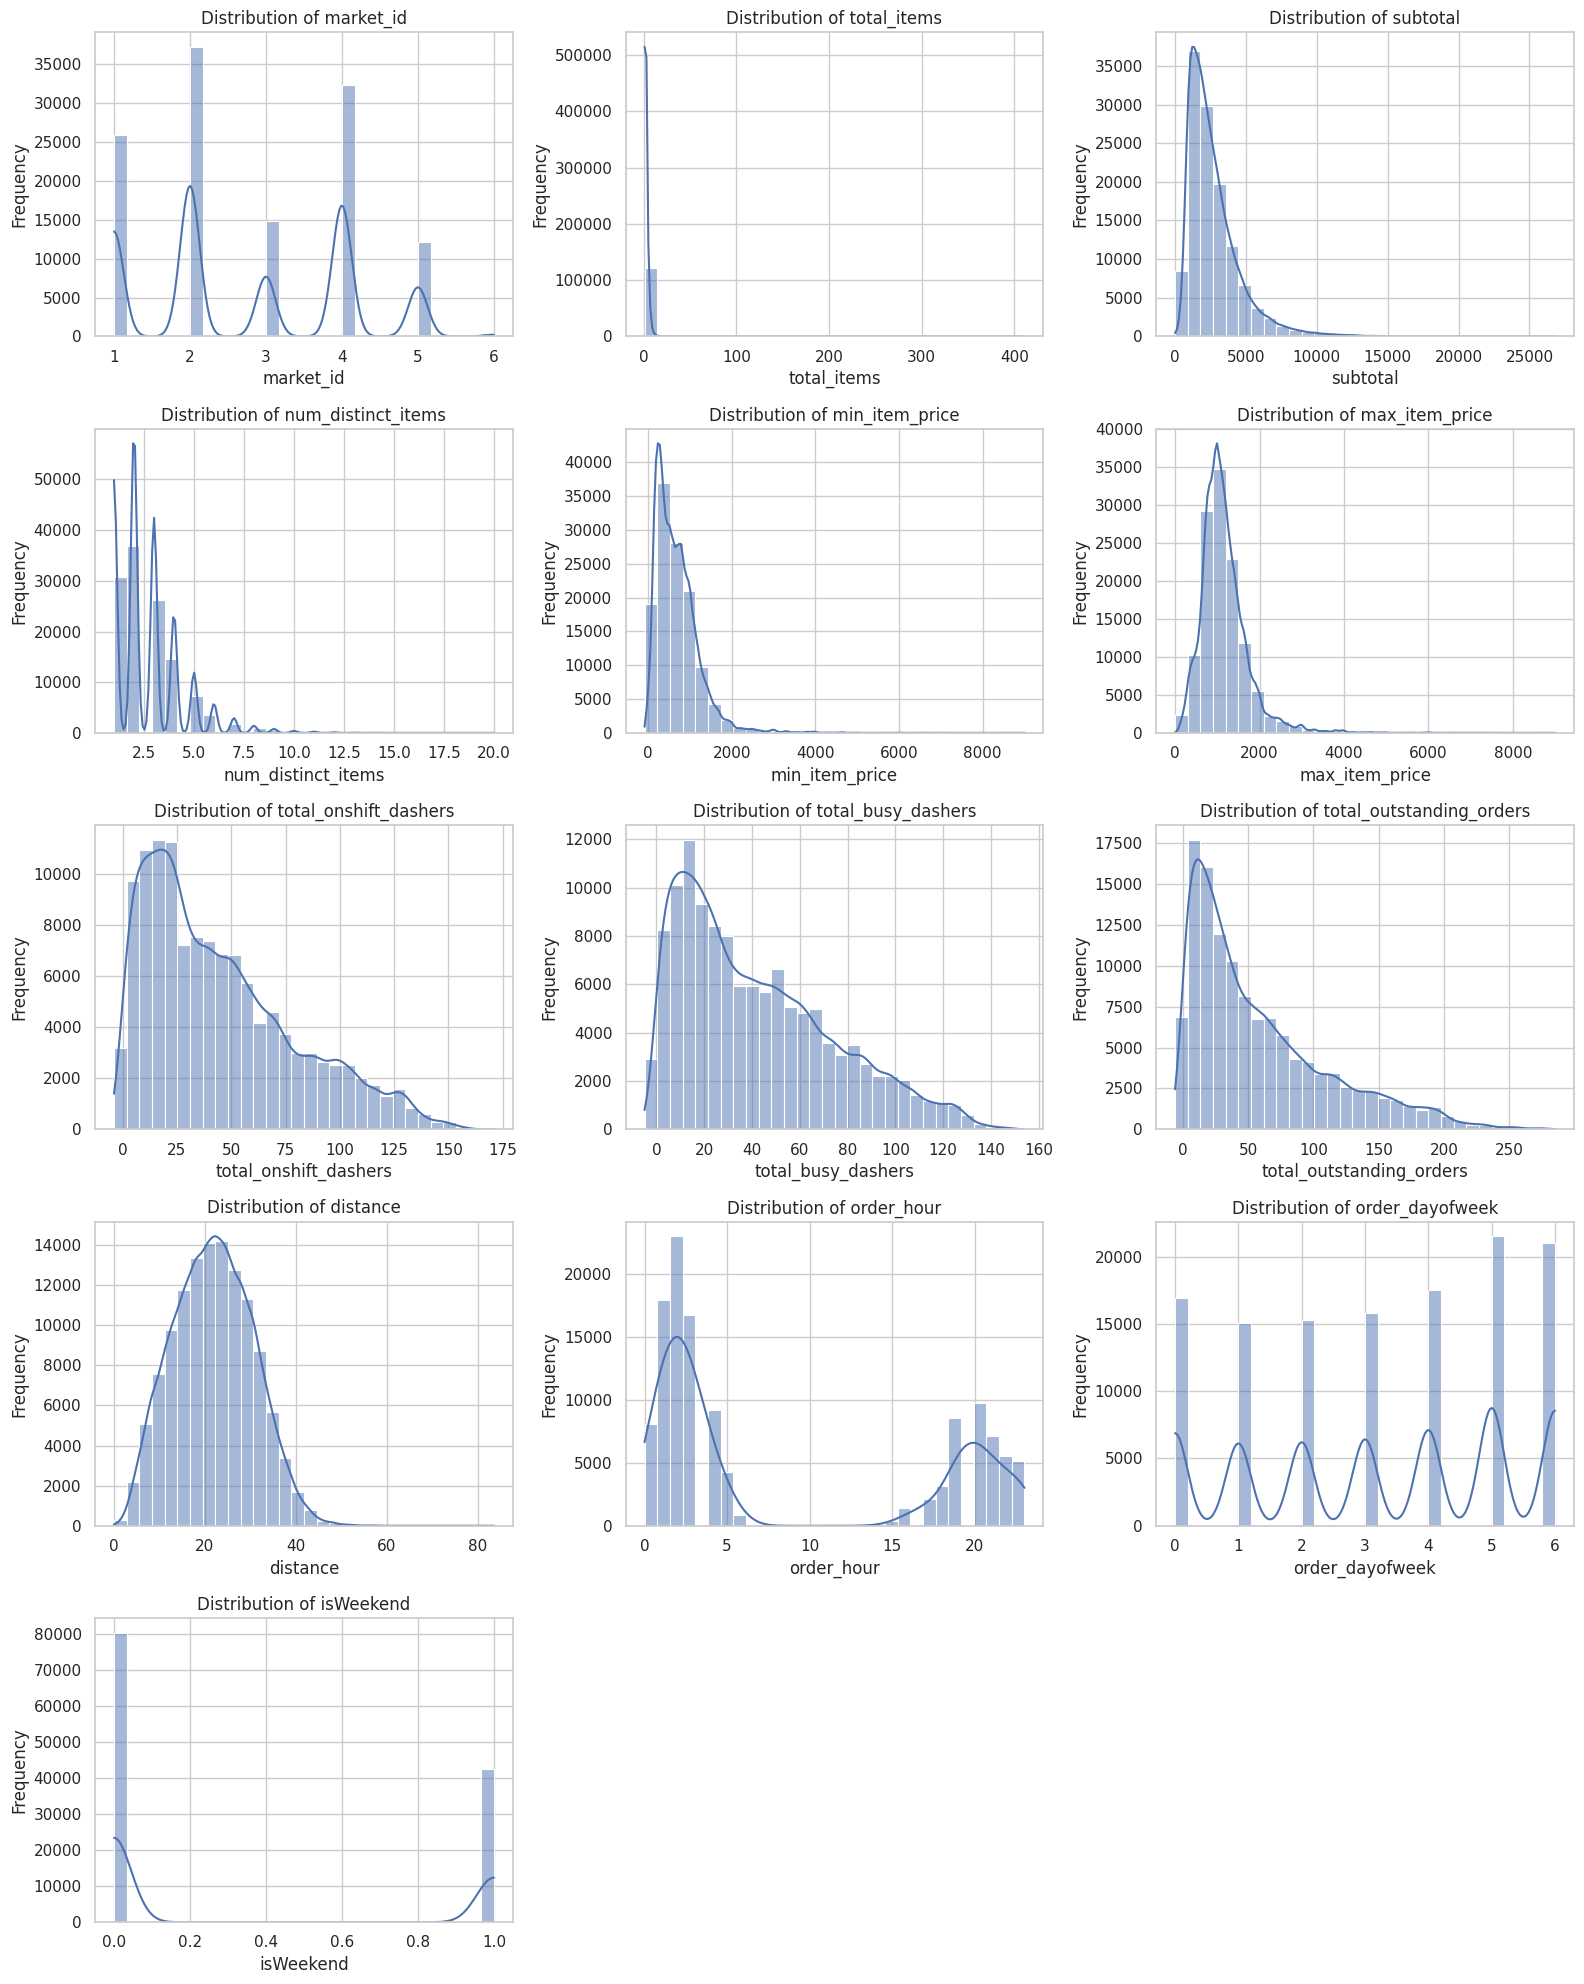

In [21]:
# Plot distributions for all numerical columns

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 20))

# Plot all numerical features
for idx, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, idx + 1)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

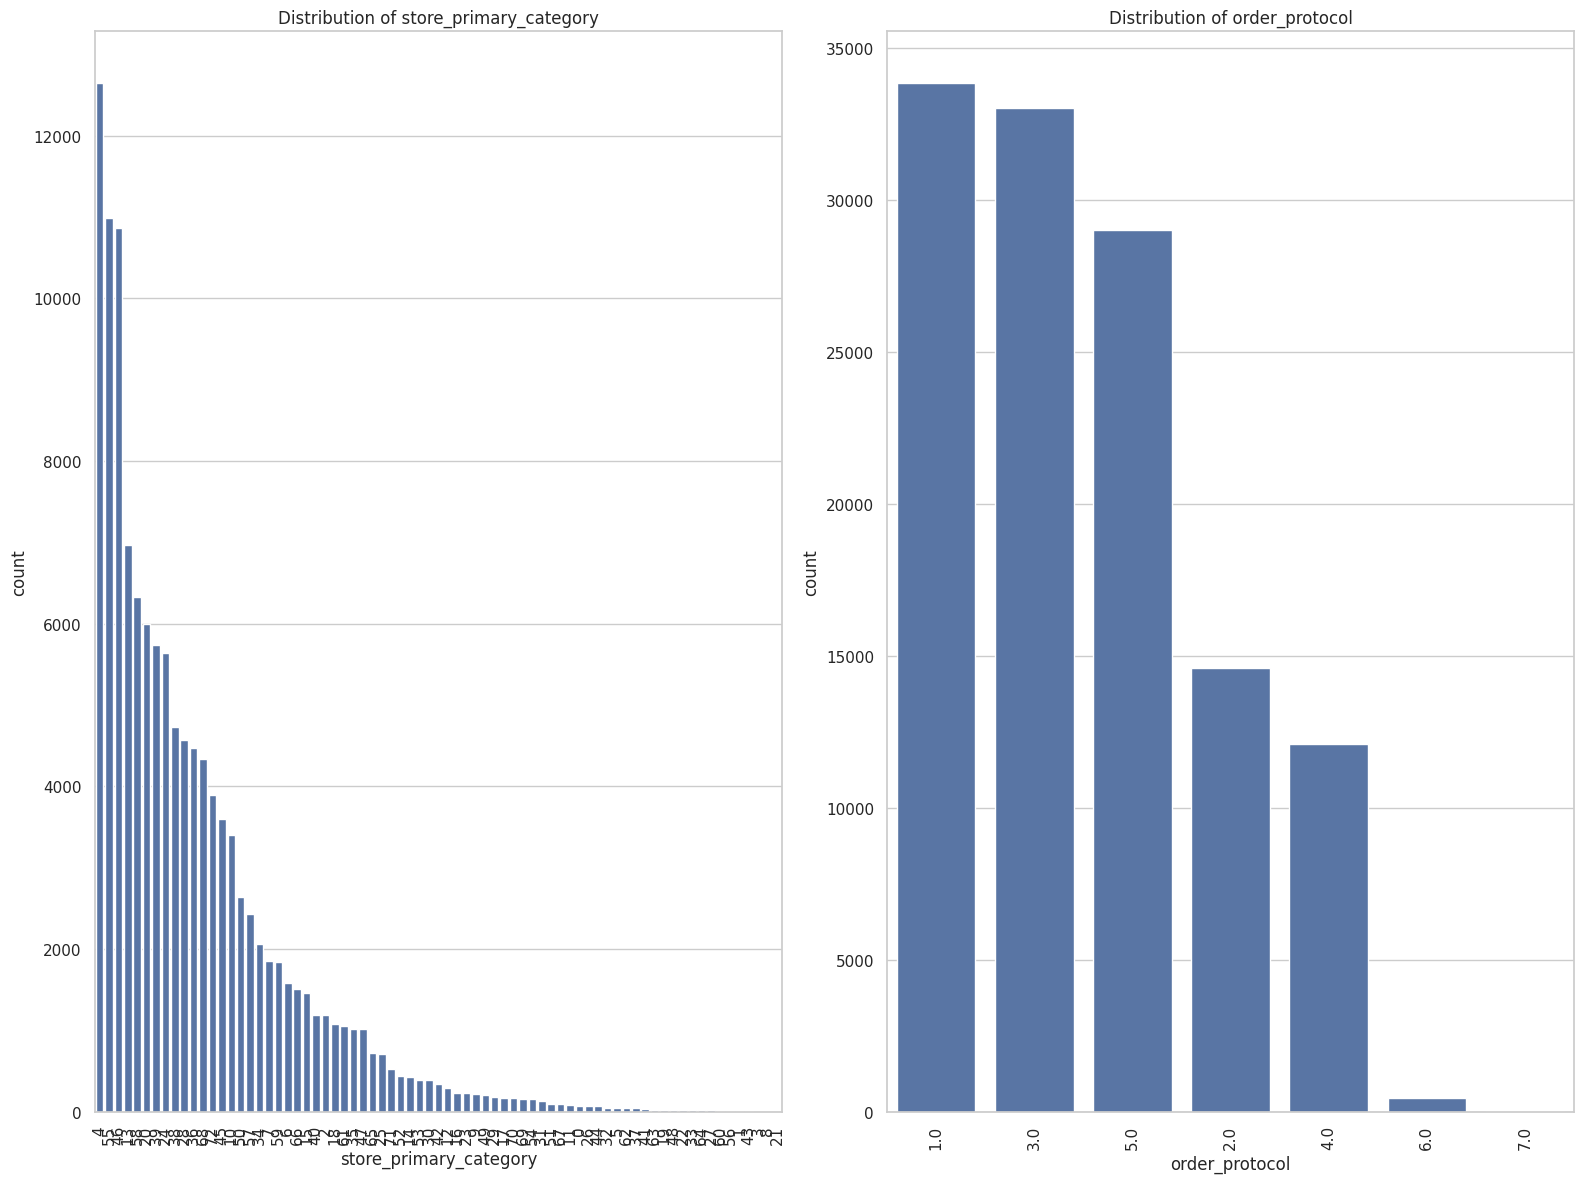

In [47]:
# Distribution of categorical columns

plt.figure(figsize=(16, 12))

for idx, col in enumerate(categorical_cols):
    plt.subplot((len(categorical_cols) + 1) // 2, 2, idx + 1)
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

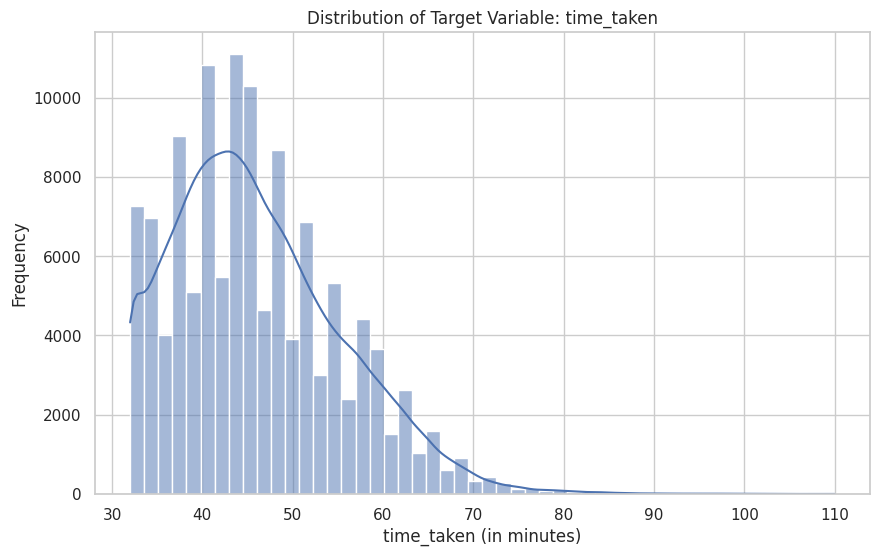

In [48]:
# Distribution of time_taken

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribution of Target Variable: time_taken')
plt.xlabel('time_taken (in minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

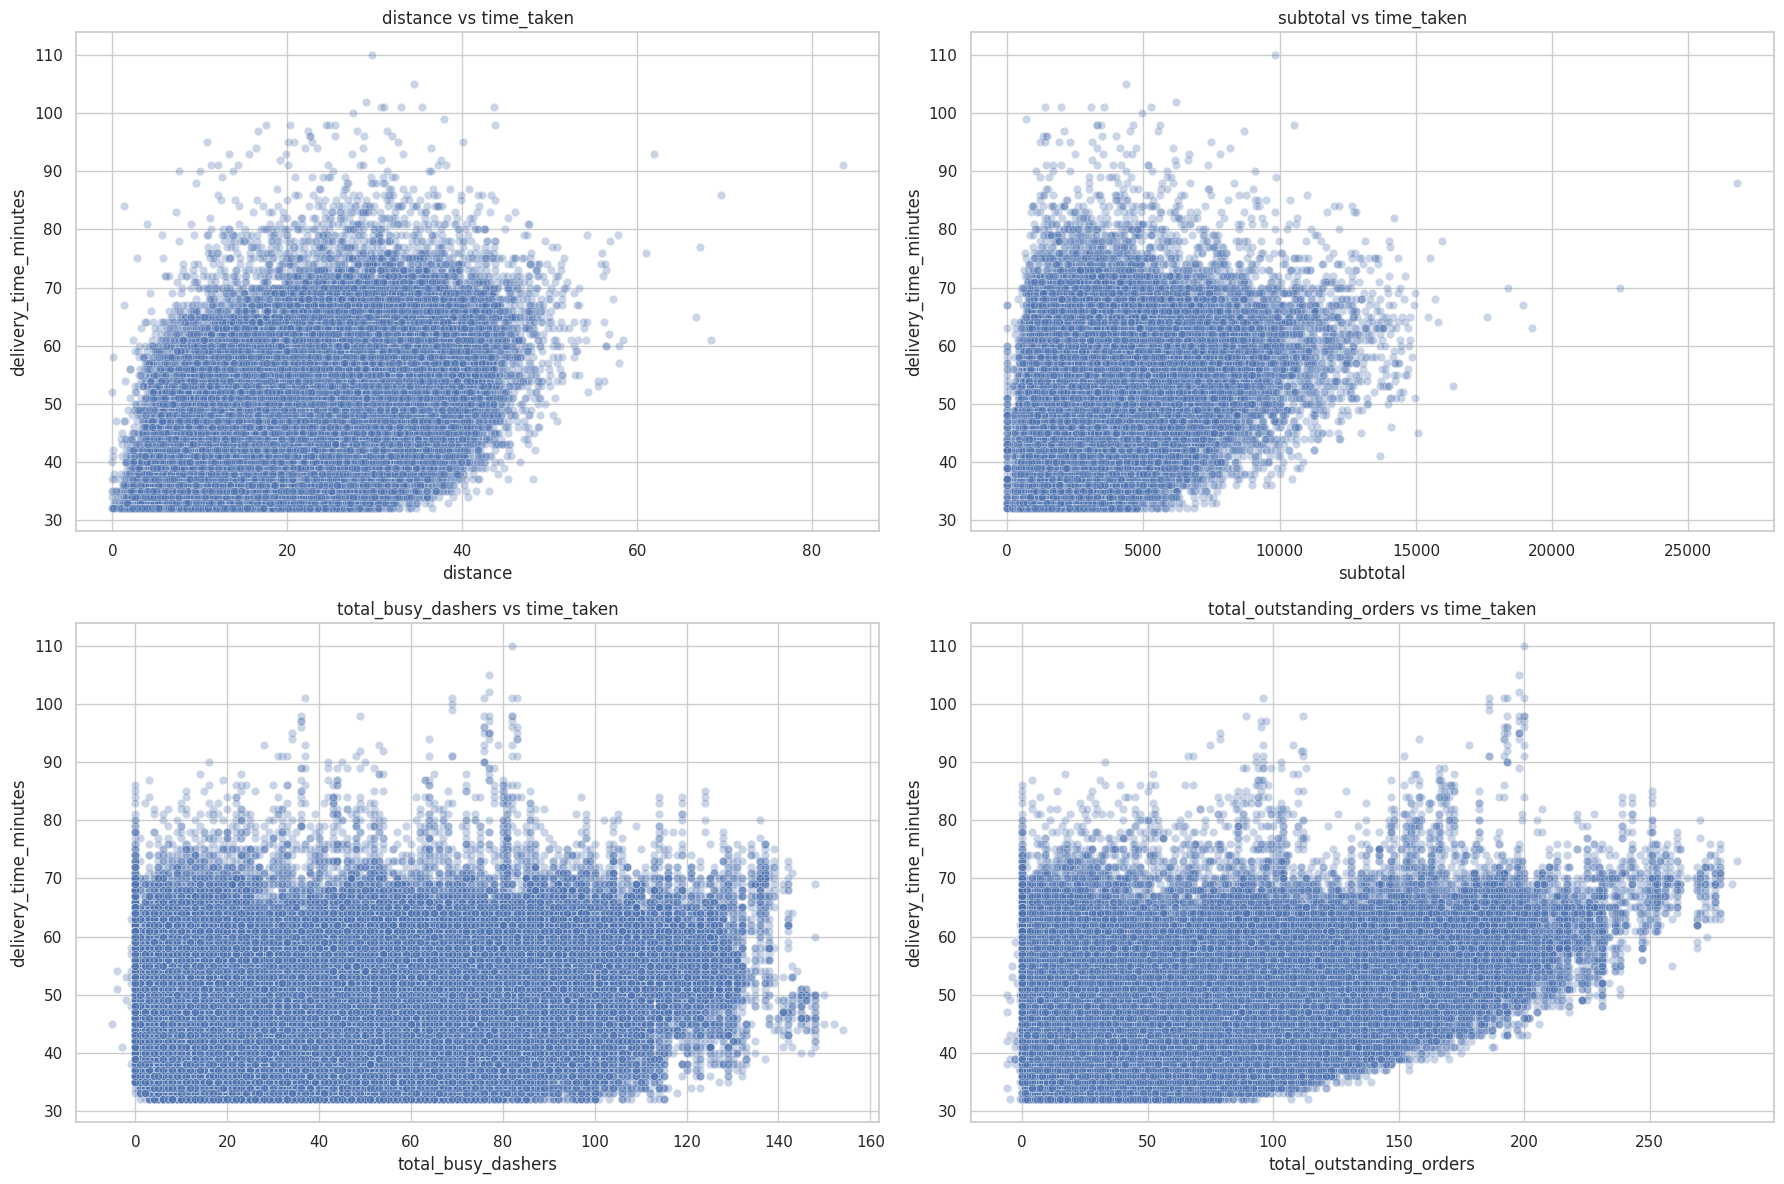

In [49]:
# Scatter plot to visualise the relationship between time_taken and other features

sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

# Scatter plots for numerical features
numerical_features = ['distance', 'subtotal', 'total_busy_dashers', 'total_outstanding_orders']
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.3)
    plt.title(f'{feature} vs time_taken')

plt.tight_layout()
plt.show()



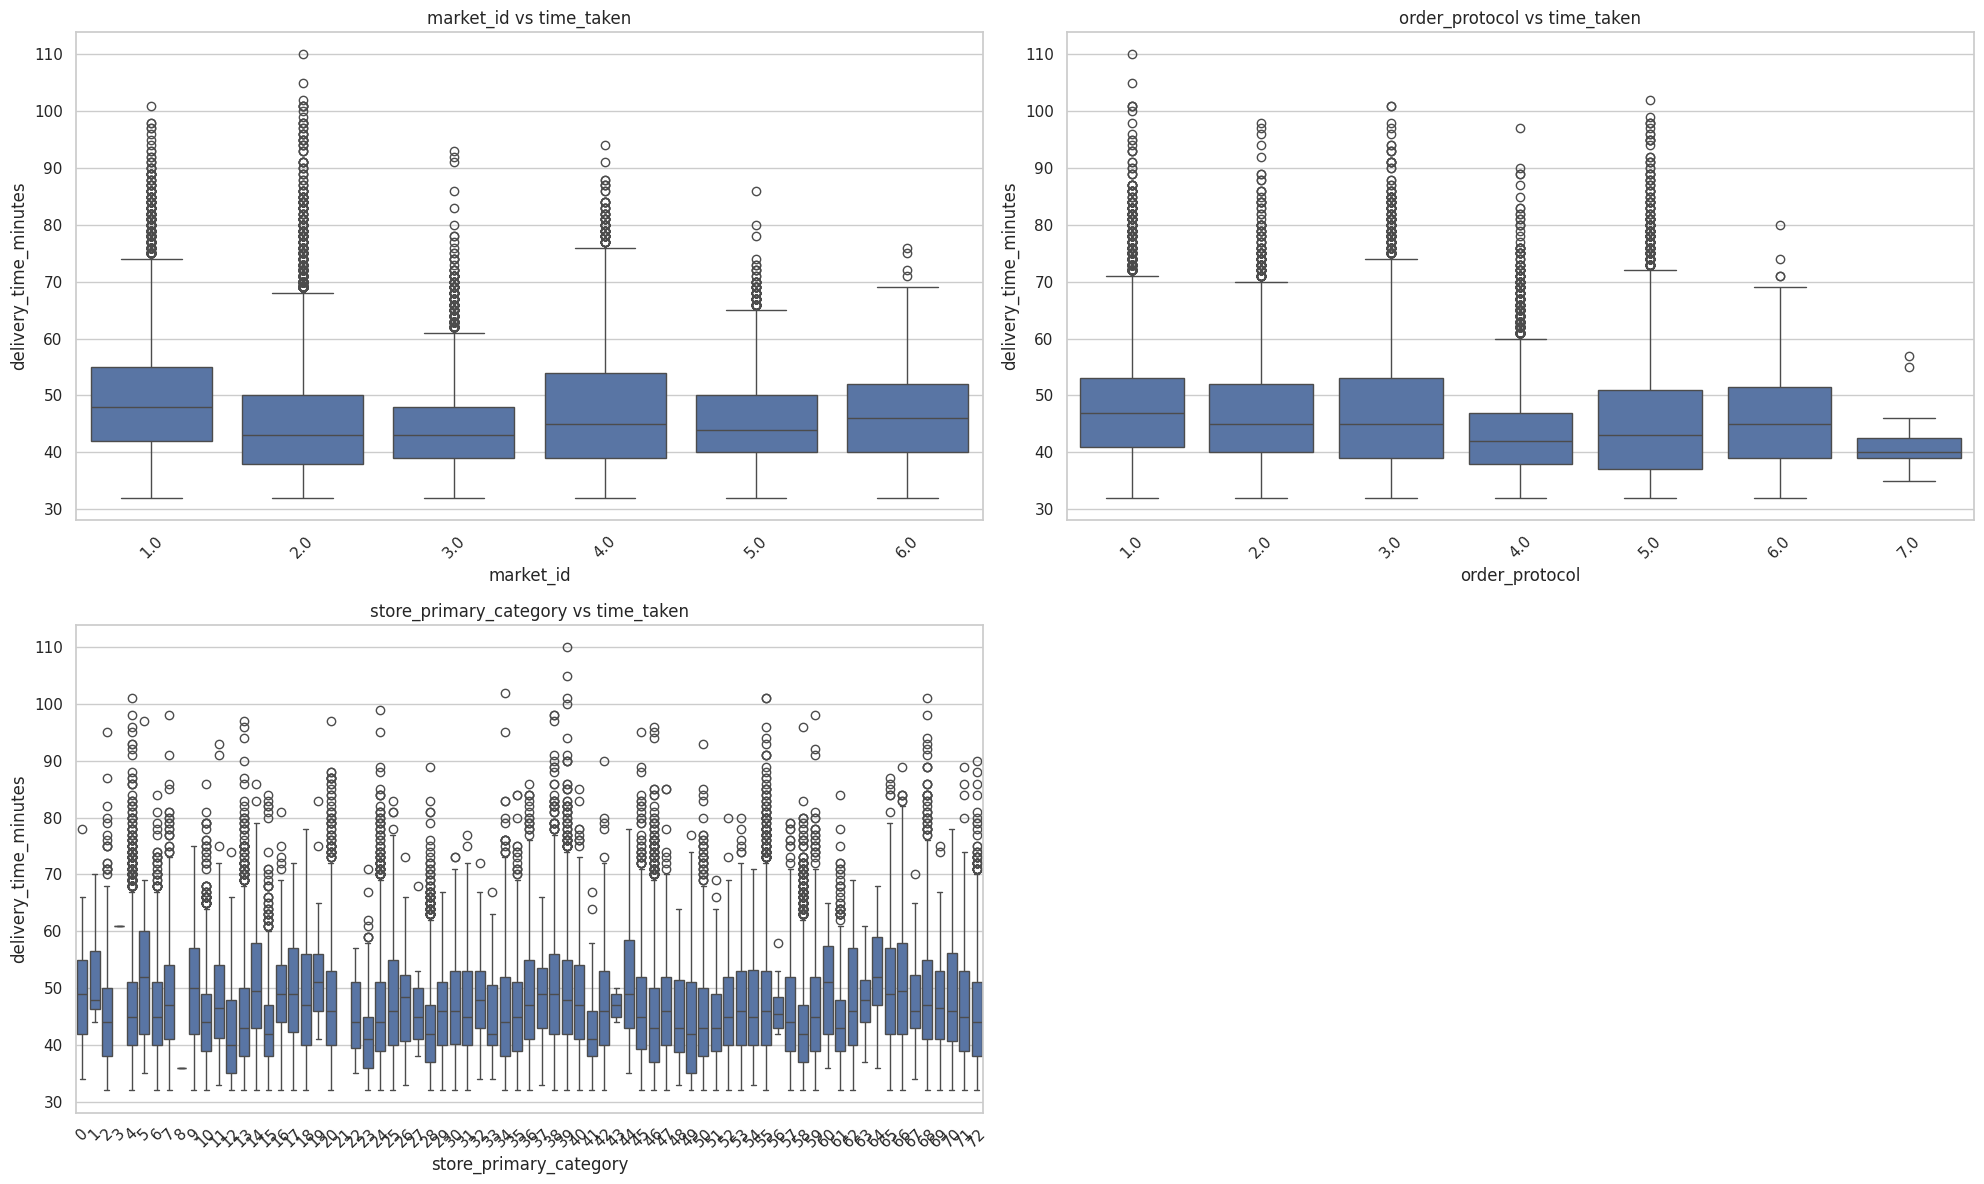

In [50]:
# Box plots for categorical features
categorical_features = ['market_id', 'order_protocol', 'store_primary_category']
plt.figure(figsize=(20, 12))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=X_train[feature], y=y_train)
    plt.xticks(rotation=45)
    plt.title(f'{feature} vs time_taken')

plt.tight_layout()
plt.show()


In [52]:
print(df.columns)

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'delivery_time_minutes',
       'order_hour', 'order_dayofweek', 'isWeekend'],
      dtype='object')


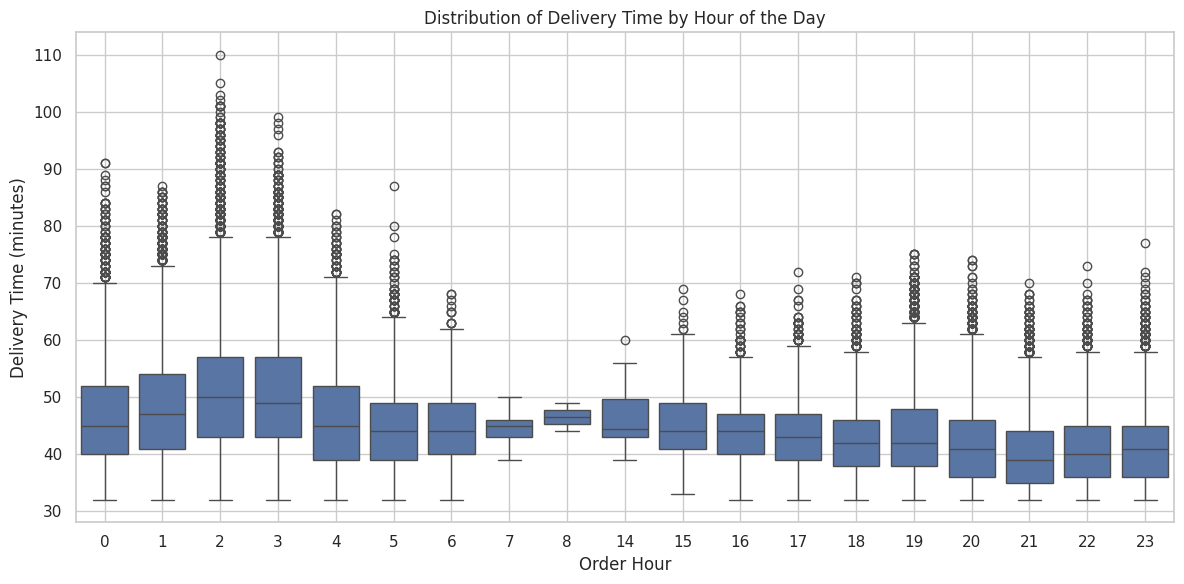

In [54]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='order_hour', y='delivery_time_minutes')

plt.title('Distribution of Delivery Time by Hour of the Day')
plt.xlabel('Order Hour')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

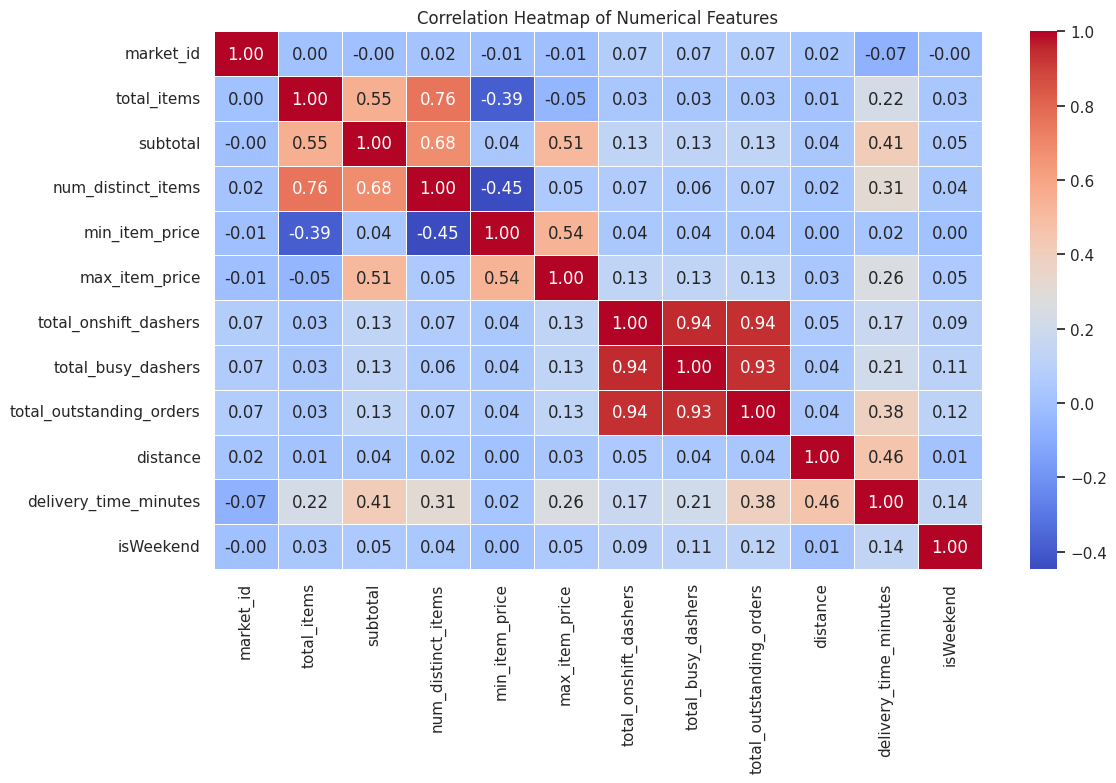

In [55]:
# Plot the heatmap of the correlation matrix

# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
correlation_matrix = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [57]:
# Drop 3-5 weakly correlated columns from training dataset

cols_to_drop = ['market_id', 'min_item_price', 'total_onshift_dashers']

# Drop from both training and validation sets
X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

# Confirm new shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)



X_train shape: (123043, 12)
X_val shape: (52734, 12)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

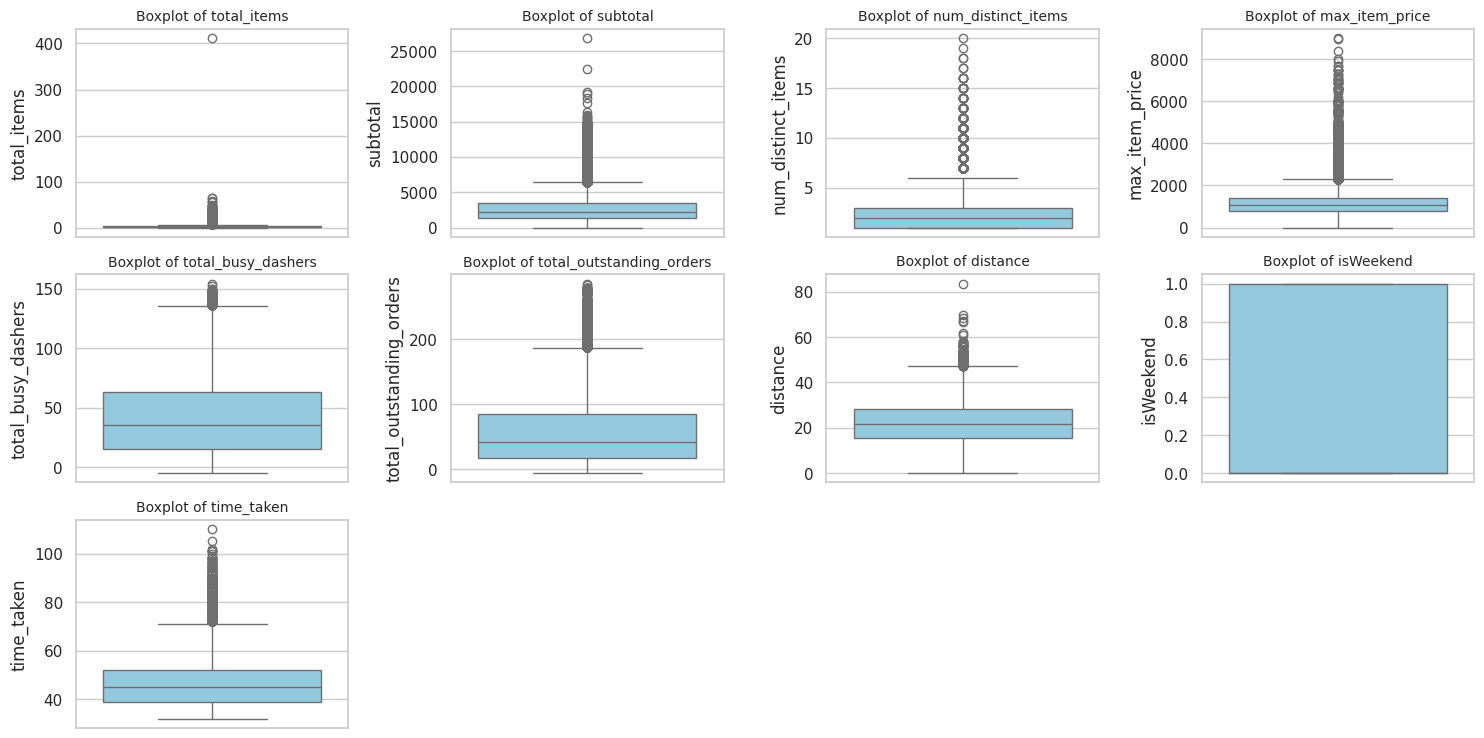

In [58]:
# Boxplot for time_taken

# Combine X_train and y_train for easier visualization
train_combined = X_train.copy()
train_combined['time_taken'] = y_train

# Set plot style
plt.figure(figsize=(15, 10))

# Create boxplots for each numerical feature including target
numerical_cols = train_combined.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=train_combined[col], color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=10)
    plt.tight_layout()

plt.show()



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [59]:
# Handle outliers

# Combine X and y for consistent filtering
train_combined = X_train.copy()
train_combined['time_taken'] = y_train

val_combined = X_val.copy()
val_combined['time_taken'] = y_val

# Numerical columns only
num_cols = train_combined.select_dtypes(include=['int64', 'float64']).columns

# Function to remove outliers using IQR method
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Apply to training and validation sets
train_clean = remove_outliers(train_combined, num_cols)
val_clean = remove_outliers(val_combined, num_cols)

# Separate X and y
X_train = train_clean.drop(columns='time_taken')
y_train = train_clean['time_taken']

X_val = val_clean.drop(columns='time_taken')
y_val = val_clean['time_taken']

# Final check
print("After outlier removal:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")



After outlier removal:
X_train shape: (104061, 12)
X_val shape: (44543, 12)
y_train shape: (104061,)
y_val shape: (44543,)


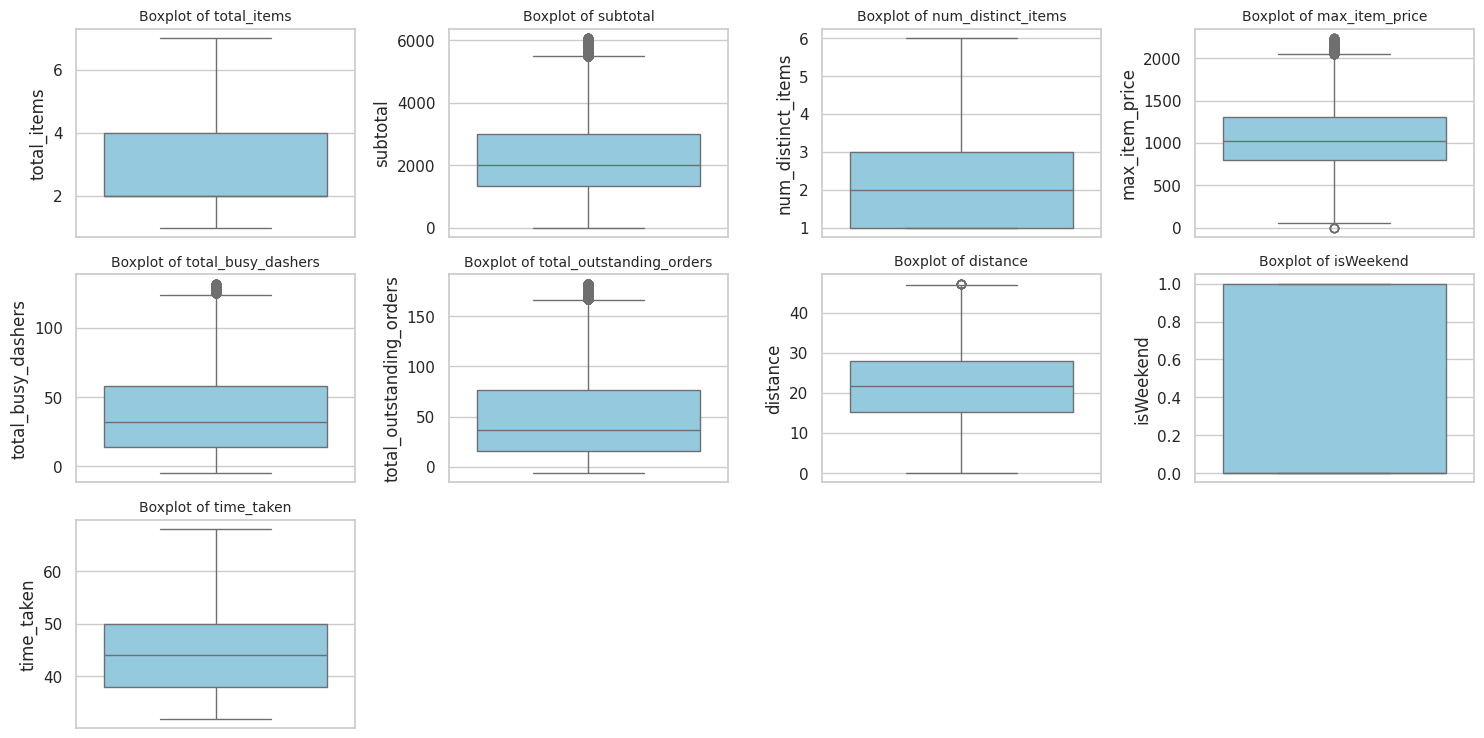

In [60]:
#checking again

train_combined = X_train.copy()
train_combined['time_taken'] = y_train

# Set plot style
plt.figure(figsize=(15, 10))

# Create boxplots for each numerical feature including target
numerical_cols = train_combined.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=train_combined[col], color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=10)
    plt.tight_layout()

plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [61]:
# Define numerical and categorical columns for easy EDA and data manipulation

all_columns = X_val.columns

# Automatically detect numerical and categorical columns
numerical_cols = X_val.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_val.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# If you know your binary flags (e.g. isWeekend) are stored as int but categorical in nature, you can do:
binary_cats = ['isWeekend']  # update if you have more

# Final lists
numerical_cols = [col for col in numerical_cols if col not in binary_cats]
categorical_cols = categorical_cols + binary_cats

# Output result
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

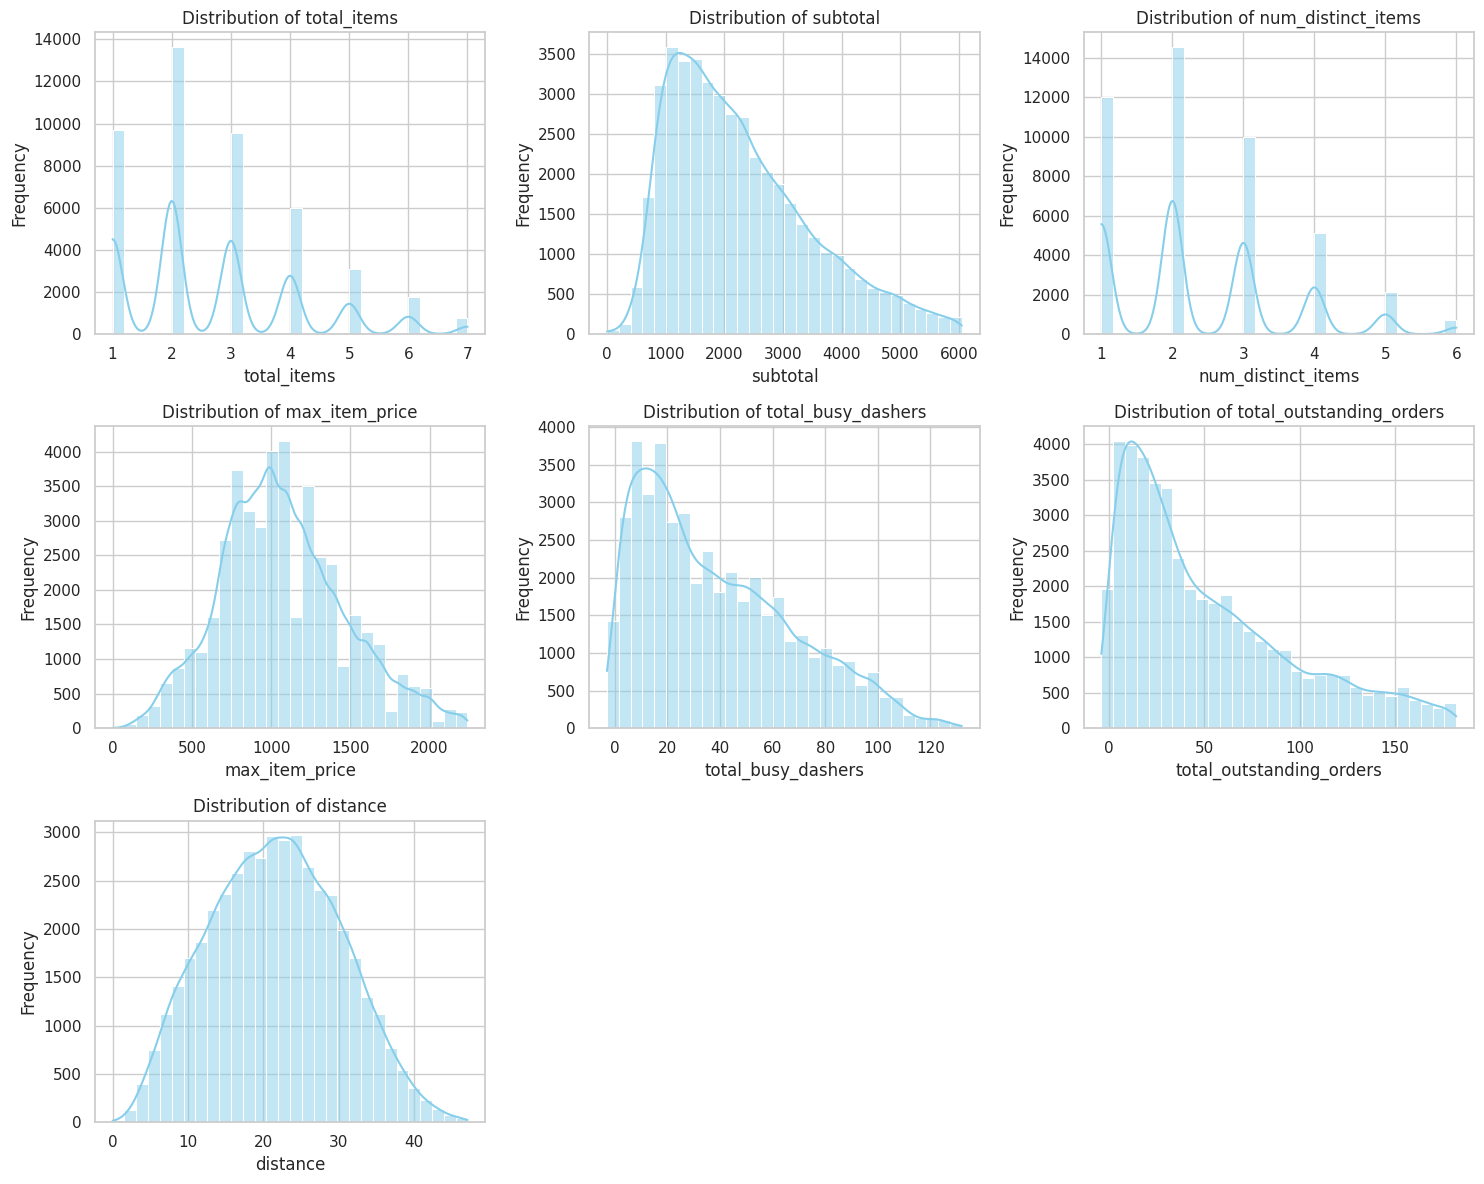

In [62]:
# Plot distributions for all numerical columns

sns.set(style="whitegrid")

# Create subplots
num_cols = numerical_cols  # defined earlier
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(X_val[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



##### **4.1.2**

Check the distribution of categorical features

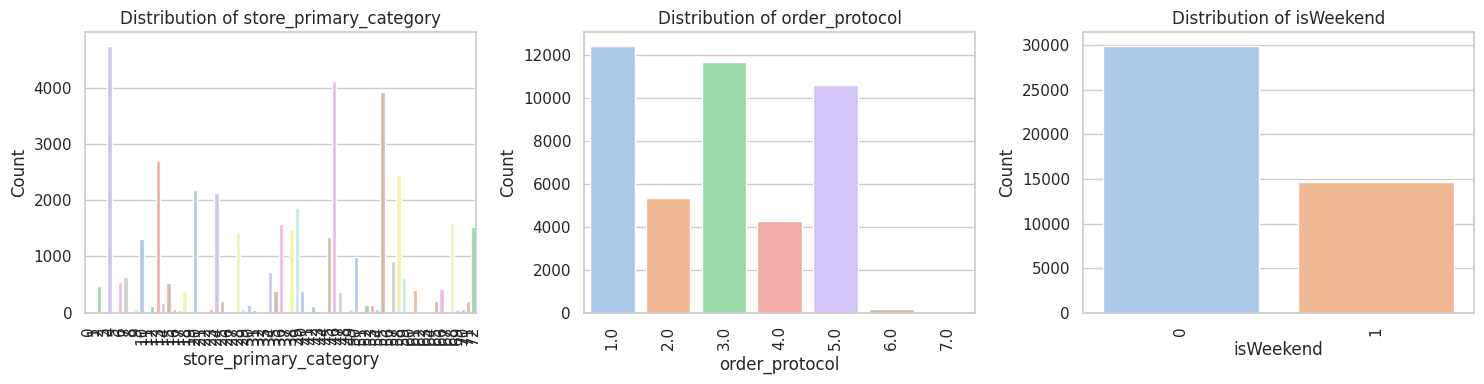

In [64]:
# Distribution of categorical columns

# Plot distributions of categorical features
import matplotlib.pyplot as plt
import seaborn as sns

# Set up grid
cat_cols = categorical_cols  # assuming this is defined earlier
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.countplot(data=X_val, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

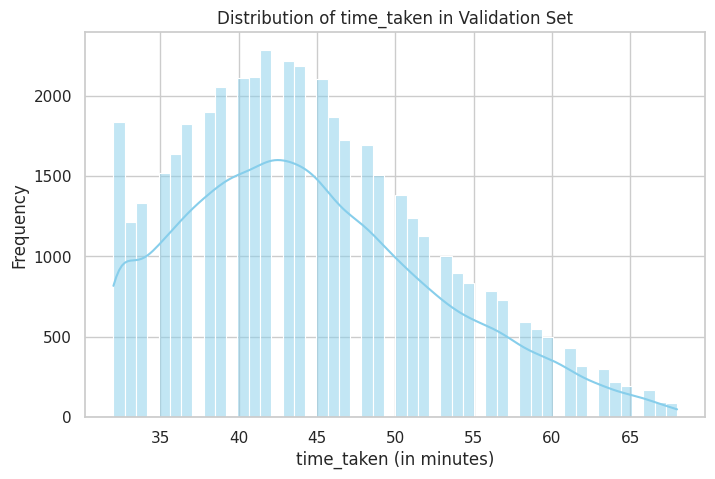

In [65]:
# Distribution of time_taken
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(y_val, kde=True, bins=50, color='skyblue')
plt.title('Distribution of time_taken in Validation Set')
plt.xlabel('time_taken (in minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

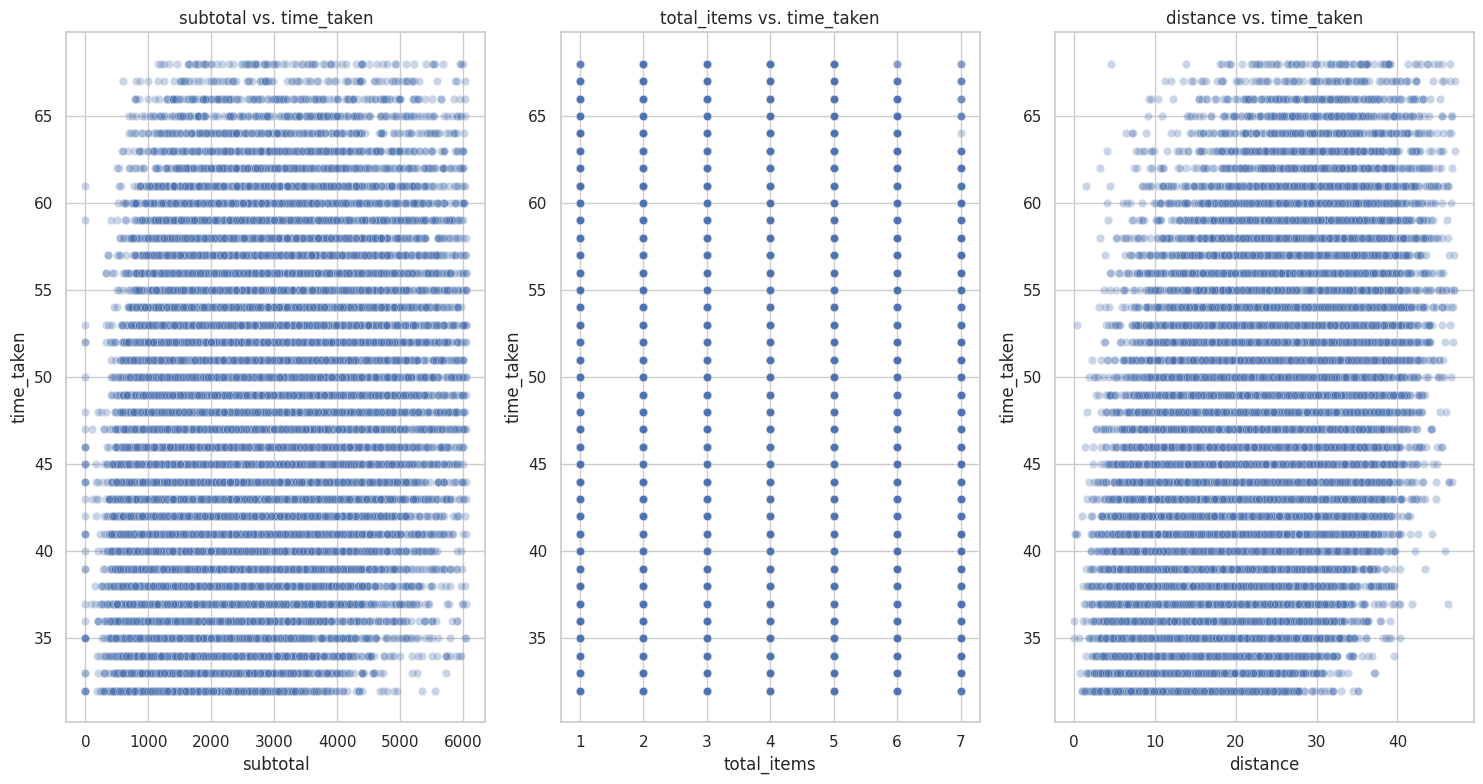

In [67]:
# Scatter plot to visualise the relationship between time_taken and other features

# Updated list of valid numerical features (exclude delivery_time_minutes)
numerical_features = ['subtotal', 'total_items', 'distance']

# Plot scatter plots
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=X_val[col], y=y_val, alpha=0.3)
    plt.title(f'{col} vs. time_taken')
    plt.xlabel(col)
    plt.ylabel('time_taken')

plt.tight_layout()
plt.show()



#### **4.3** Drop the columns with weak correlations with the target variable

In [72]:
# Drop the weakly correlated columns from training dataset
correlation_with_target = df.corr(numeric_only=True)['delivery_time_minutes'].sort_values()
print(correlation_with_target)




order_hour                 -0.346366
market_id                  -0.073016
min_item_price              0.022753
order_dayofweek             0.045878
isWeekend                   0.136414
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
delivery_time_minutes       1.000000
Name: delivery_time_minutes, dtype: float64


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [74]:
# Import libraries

from sklearn.linear_model import LinearRegression

# For model evaluation
from sklearn.metrics import mean_squared_error, r2_score


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [76]:
# Apply scaling to the numerical columns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define numerical columns
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price',
                  'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_minutes']

# Define categorical columns
categorical_cols = ['store_primary_category', 'order_protocol', 'order_hour', 'order_dayofweek', 'isWeekend']

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', categorical_cols)  # keep categorical columns unchanged for now
    ]
)


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [78]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

model = LinearRegression()



In [79]:
# Train the model using the training data
model.fit(X_train, y_train)


LinearRegression()

In [80]:
# Make predictions
y_pred = model.predict(X_val)


In [81]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)



MAE: 3.465379793116986
MSE: 20.372935655276788
RMSE: 4.513638848565178
R² Score: 0.6829349689165176


In [83]:
import statsmodels.api as sm

# Add constant (intercept term)
X_train_sm = sm.add_constant(X_train)

# Build the model
model = sm.OLS(y_train, X_train_sm).fit()

# Summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 1.858e+04
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:04:09   Log-Likelihood:            -3.0494e+05
No. Observations:              104061   AIC:                         6.099e+05
Df Residuals:                  104048   BIC:                         6.100e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Store results
feature_scores = {}

# Loop over each feature
for col in X_train.columns:
    # Train using only one feature
    X_train_single = X_train[[col]]
    X_val_single = X_val[[col]]

    model = LinearRegression()
    model.fit(X_train_single, y_train)

    # Predict
    y_pred = model.predict(X_val_single)

    # Evaluate
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    feature_scores[col] = {'R2': r2, 'RMSE': rmse}

# Sort by R2
sorted_scores = dict(sorted(feature_scores.items(), key=lambda x: x[1]['R2'], reverse=True))

# Display
import pandas as pd
pd.DataFrame(sorted_scores).T


R2      RMSE
distance                  0.242718  6.975598
subtotal                  0.115415  7.539149
order_hour                0.107004  7.574907
total_outstanding_orders  0.083604  7.673513
num_distinct_items        0.060773  7.768512
total_items               0.049711  7.814129
max_item_price            0.048108  7.820715
order_protocol            0.026025  7.910912
isWeekend                 0.014987  7.955614
total_busy_dashers        0.011790  7.968514
order_dayofweek           0.004831  7.996519
store_primary_category    0.000376  8.014398

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [85]:
# Loop through the number of features and test the model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


model = LinearRegression()

# 2. Store results
r2_scores = []
rmse_scores = []
num_features_list = []

# 3. Loop through 1 to total number of features
for n_features in range(1, X_train.shape[1] + 1):
    # Apply RFE
    rfe = RFE(model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)

    # Train the model
    model.fit(X_train_rfe, y_train)

    # Predict
    y_pred = model.predict(X_val_rfe)

    # Evaluate
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # Store
    num_features_list.append(n_features)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# 4. Show results
for i in range(len(num_features_list)):
    print(f"{num_features_list[i]} features => R²: {r2_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}")



1 features => R²: 0.0150, RMSE: 7.9556
2 features => R²: 0.0724, RMSE: 7.7201
3 features => R²: 0.0953, RMSE: 7.6243
4 features => R²: 0.3347, RMSE: 6.5384
5 features => R²: 0.3375, RMSE: 6.5243
6 features => R²: 0.3378, RMSE: 6.5230
7 features => R²: 0.3467, RMSE: 6.4789
8 features => R²: 0.6077, RMSE: 5.0204
9 features => R²: 0.6553, RMSE: 4.7060
10 features => R²: 0.6557, RMSE: 4.7035
11 features => R²: 0.6827, RMSE: 4.5155
12 features => R²: 0.6829, RMSE: 4.5136


In [86]:
# Build the final model with selected number of features
# Choose number of features
n_selected = 9

# Apply RFE again with n_selected
final_rfe = RFE(model, n_features_to_select=n_selected)
X_train_rfe = final_rfe.fit_transform(X_train, y_train)
X_val_rfe = final_rfe.transform(X_val)

# Final model training
model.fit(X_train_rfe, y_train)

# Prediction and evaluation
y_pred = model.predict(X_val_rfe)
final_r2 = r2_score(y_val, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Print results
print(f"Final Model with {n_selected} features => R²: {final_r2:.4f}, RMSE: {final_rmse:.4f}")

# Show selected features
selected_features = X_train.columns[final_rfe.support_]
print("Selected Features:")
print(selected_features)



Final Model with 9 features => R²: 0.6553, RMSE: 4.7060
Selected Features:
Index(['order_protocol', 'total_items', 'num_distinct_items',
       'total_busy_dashers', 'total_outstanding_orders', 'distance',
       'order_hour', 'order_dayofweek', 'isWeekend'],
      dtype='object')


In [89]:
# Add constant (intercept term)
X_train_sm = sm.add_constant(X_train)

# Build the model
model = sm.OLS(y_train, X_train_sm).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 1.858e+04
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:33:25   Log-Likelihood:            -3.0494e+05
No. Observations:              104061   AIC:                         6.099e+05
Df Residuals:                  104048   BIC:                         6.100e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [92]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Replace this with your selected features (from RFE or correlation analysis)
selected_features = ['distance', 'subtotal', 'order_hour', 'total_outstanding_orders',
                     'num_distinct_items', 'total_items', 'max_item_price',
                     'order_protocol', 'isWeekend', 'total_busy_dashers',
                     'order_dayofweek', 'store_primary_category']

X = df[selected_features]
y = df['delivery_time_minutes']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [93]:
# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
final_preds = model.predict(X_test)


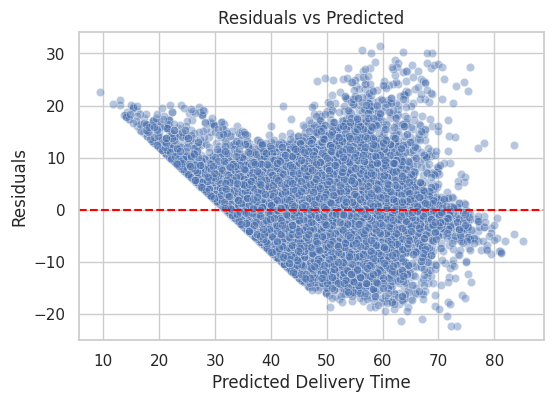

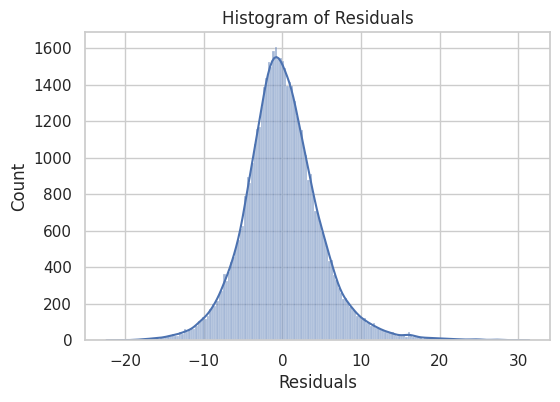

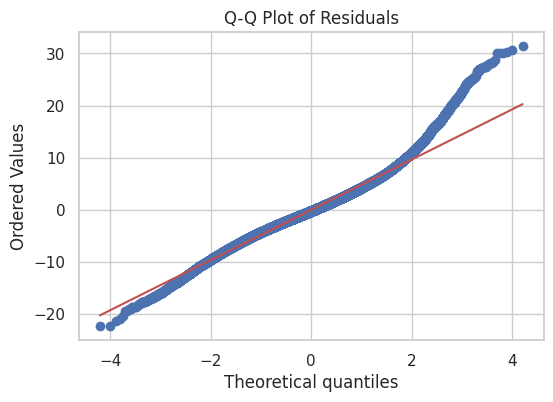

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals
residuals = y_test - final_preds

# 1. Residuals vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=final_preds, y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

# 3. Q-Q Plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


In [ ]:
##going with other method to improve R Sq.

In [95]:
import numpy as np
y_log = np.log1p(y)

# Then use y_log for training and inverse transform after prediction:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)


In [98]:
import numpy as np
y_train_log = np.log1p(y_train)

# Train the model (example with LinearRegression)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train_log)



LinearRegression()

In [99]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Inverse of log1p



In [100]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'R²: {r2:.4f}, RMSE: {rmse:.4f}')


R²: 0.7321, RMSE: 4.8370


In [101]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate
print(f'R²: {r2_score(y_test, y_pred):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')


R²: 0.7361, RMSE: 4.8009


[Your inferences here:]

The pattern suggests that the relationship between features and the target is not purely linear — especially for higher delivery times.



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [110]:
# Compare the scaled vs unscaled features used in the final model
features = ['store_primary_category', 'order_protocol', 'total_items', 'subtotal',
            'num_distinct_items', 'max_item_price', 'total_busy_dashers',
            'total_outstanding_orders', 'distance', 'order_hour',
            'order_dayofweek', 'isWeekend']
target = 'delivery_time_minutes'






In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X and y
X = df[features]
y = df[target]

# Train-test split (use 30% test data as you used earlier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [112]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Coefficients and feature names
coefs = lr_model.coef_
features_scaled = X.columns

# Create DataFrame
coef_df = pd.DataFrame({'Feature': features_scaled, 'Coefficient': coefs})
coef_df['Impact'] = coef_df['Coefficient'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')
coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)
print(coef_df)


                     Feature  Coefficient    Impact
7   total_outstanding_orders    12.906666  Increase
6         total_busy_dashers   -11.223851  Decrease
8                   distance     4.092000  Increase
3                   subtotal     2.289435  Increase
11                 isWeekend     2.005245  Increase
9                 order_hour    -1.749510  Decrease
10           order_dayofweek    -1.474001  Decrease
1             order_protocol    -1.110684  Decrease
4         num_distinct_items     0.810815  Increase
5             max_item_price     0.340273  Increase
0     store_primary_category     0.079556  Increase
2                total_items    -0.055726  Decrease


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [119]:
# Analyze the effect of a unit change in a feature, say 'total_items'
import pandas as pd
import numpy as np

# Step 1: Convert categorical features in X_train to numeric
X_train_numeric = X_train.copy()
for col in X_train_numeric.select_dtypes(include='category').columns:
    X_train_numeric[col] = X_train_numeric[col].cat.codes

# Step 2: Compute coefficients, feature names, and std of numeric features
coefficients = lr_model.coef_
feature_names = X_train_numeric.columns
std_original = X_train_numeric.std()

# Step 3: Build the coefficient analysis table
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (scaled)': coefficients,
    'Std_Original': std_original.values
})

coef_df['Impact_per_unit_change'] = coef_df['Coefficient (scaled)'] / coef_df['Std_Original']
coef_df['Impact_Direction'] = np.where(coef_df['Impact_per_unit_change'] > 0, 'Increase', 'Decrease')

# Step 4: Sort and display
coef_df = coef_df.sort_values(by='Impact_per_unit_change', ascending=False).reset_index(drop=True)
print(coef_df)



                     Feature  Coefficient (scaled)  Std_Original  \
0                  isWeekend              2.005245      0.475569   
1         num_distinct_items              0.810815      1.627780   
2                   distance              4.092000      8.741451   
3   total_outstanding_orders             12.906666     52.767079   
4     store_primary_category              0.079556     20.715303   
5                   subtotal              2.289435   1832.808859   
6             max_item_price              0.340273    559.948400   
7                total_items             -0.055726      2.760408   
8                 order_hour             -1.749510      8.677388   
9         total_busy_dashers            -11.223851     32.179502   
10           order_dayofweek             -1.474001      2.044417   
11            order_protocol             -1.110684      1.512631   

    Impact_per_unit_change Impact_Direction  
0                 4.216517         Increase  
1                 0.498

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>store_primary_category,order_protocol,order_dayofweek,isWeekend.

Inference: Different store types slightly affect delivery time, but the impact is small.
Some order methods may streamline the process, reducing delivery time.
Weekdays tend to have slightly shorter delivery times than weekends.
Deliveries on weekends are slower, possibly due to higher demand/traffic.







---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test_size = 0.2 refers to 20% of the dataset would be used as the test data, and the remaining 80% will be used as the training data.





---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Distance



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>I used a combination of visual plots, IQR-based thresholds, and domain rules to detect outliers. I addressed them by removing irrelevant records, leading to cleaner data and more accurate model results.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>total_outstanding_orders,total_busy_dashers,distance



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more independent (input) variables. It assumes a linear relationship between the dependent variable y and the independent variable(s) X.

Types of Linear Regression
Simple Linear Regression- One independent variable

Multiple Linear Regression-Two or more independent variables




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple Linear Regression- One independent variable

Multiple Linear Regression-Two or more independent variables



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>In linear regression, the cost function serves as a measure of error — it tells us how far off our predicted values are from the actual values. The goal of linear regression is to find the best-fitting line through the data by minimizing this error




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting occurs when a model learns the training data too well, including the noise, and performs poorly on new data. Underfitting, conversely, happens when a model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and new data.




---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots, which display residuals i.e., the differences between observed and predicted values against the independent variable, are a crucial tool for diagnosing the validity of a linear regression model.